In [1]:
%load_ext autoreload
%autoreload 2

## Simple Fixation Map training (2 layers)
with clutter / whitening

In [2]:
%matplotlib inline

In [3]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import noise
import MotionClouds as mc

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import PIL


In [6]:
verbose = True

In [7]:
import sys
sys.path.append('../figures')
from retina import MotionCloudNoise, vectorization, get_data_loader, minmax

In [8]:
N_theta = 6
N_azimuth = 16
N_eccentricity = 10
N_phase = 2

N_pic = 128
N_X = N_pic
N_Y = N_pic
rho = 1.41
verbose = 1


In [9]:
retina_transform = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)

In [10]:
# retina_vector = retina.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
# retina_inverse = np.linalg.pinv(retina_vector)

In [11]:
loader = get_data_loader(batch_size=100, train = False)

In [12]:
path = "MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy_map =  np.load(path)
    if verbose:
        print('Loading accuracy... min, max=', accuracy_map.min(), accuracy_map.max())
else:
    print('No accuracy data found.')

Loading accuracy... min, max= 0.0145 0.9852


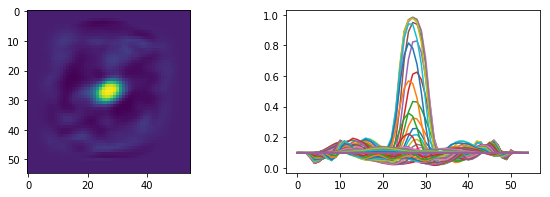

In [13]:
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(accuracy_map)
plt.subplot(122)
_ = plt.plot(accuracy_map)

### From MNIST encoding

#### Input vectors encoding

In [14]:
from retina import place_object, accuracy_fullfield

# Hyperparameters

In [15]:


minibatch_size = 100  # quantity of examples that'll be processed
lr = 1e-4 #1e-3  #0.05
OFFSET_STD = 15 #
OFFSET_MAX = 30 #
NOISE = 1 #0 #
CONTRAST = 0.3 #1 #
sf_0 = 0.2
B_sf = 0.3

### Test

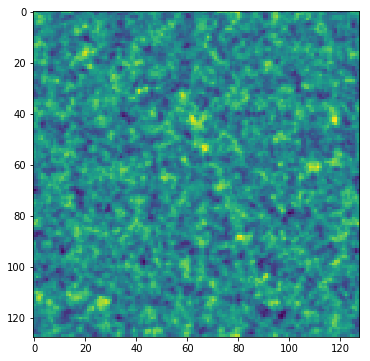

In [16]:
data, label = next(iter(loader))
if True:
    i = 4
    offset_std=OFFSET_STD
    offset_max=OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    data_fullfield = place_object(data[i, 0, :, :].numpy(), i_offset, j_offset,  
                                    CONTRAST=CONTRAST, NOISE=NOISE,
                                    sf_0=sf_0, B_sf=B_sf)
    #plt.imshow(input_test)
    plt.figure(figsize = (20,6))
    plt.subplot(111)
    plt.imshow(data_fullfield)


In [17]:
from retina import retina, retina_inverse
retina_inverse_transform = retina_inverse(retina_transform)

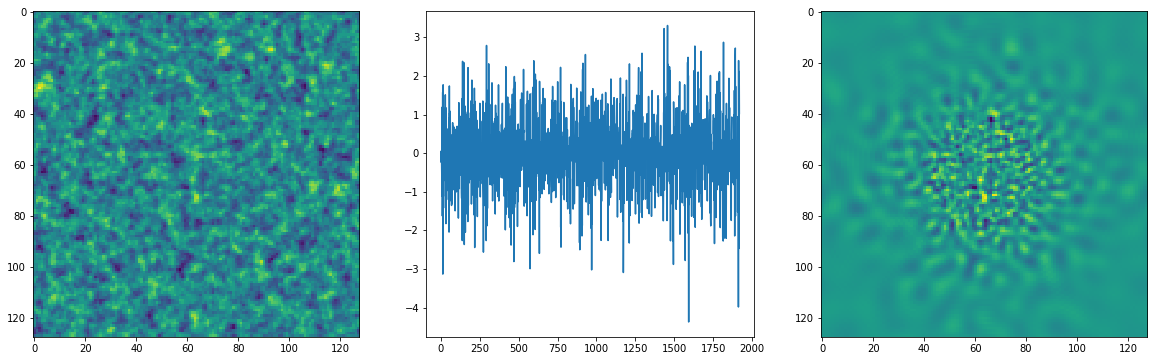

In [18]:
data, label = next(iter(loader))
if True:
    i = 4
    offset_std=OFFSET_STD
    offset_max=OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    data_fullfield = place_object(data[i, 0, :, :].numpy(), i_offset, j_offset, 
                                    CONTRAST=CONTRAST, NOISE=NOISE,
                                    sf_0=sf_0, B_sf=B_sf)
    data_retina, tensor_retina  =  retina(data_fullfield, retina_transform)

    #plt.imshow(input_test)
    plt.figure(figsize = (20,6))
    plt.subplot(131)
    plt.imshow(data_fullfield)
    plt.subplot(132)
    f = plt.plot(data_retina)
    plt.subplot(133)
    plt.imshow((retina_inverse_transform @ data_retina).reshape(128, 128))


#### Orientation invariant power encoding (colliculus??)

In [37]:
from retina import do_offset, accuracy_fullfield

In [38]:
colliculus = (retina_transform**2).sum(axis=(0, 3))
#colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(16, 10, 16384)


In [39]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(160, 16384)


In [40]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

(16384, 160)


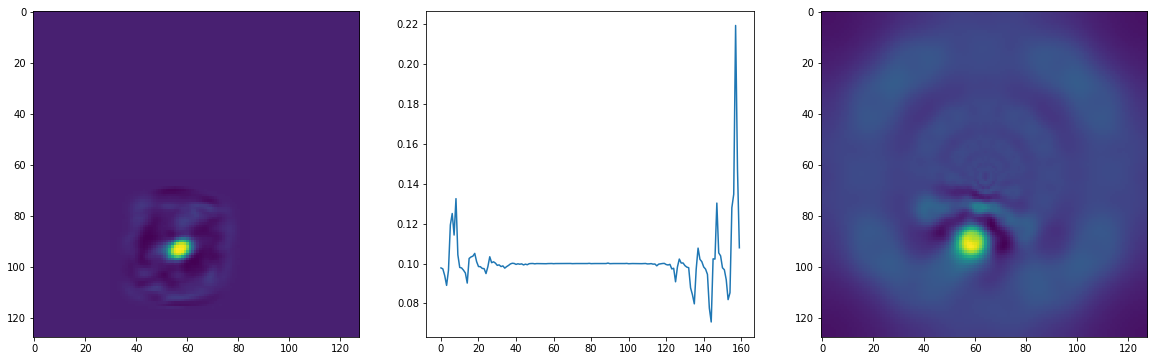

In [42]:
if True:
    i = 4
    offset_std=OFFSET_STD
    offset_max=OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    accuracy_fullfield_map = do_offset(accuracy_map, i_offset, j_offset, N_pic=128, min=0.1)
    accuracy_colliculus = colliculus_vector @ accuracy_fullfield_map.ravel()
    #plt.imshow(input_test)
    plt.figure(figsize = (20,6))
    plt.subplot(131)
    plt.imshow(accuracy_fullfield_map)
    plt.subplot(132)
    f = plt.plot(accuracy_colliculus)
    plt.subplot(133)
    im = colliculus_inverse @ accuracy_colliculus
    plt.imshow(im.reshape(128, 128))
    


#### Torch stuff

In [43]:
do_cuda = False # torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if do_cuda else {}
device = torch.device("cuda" if do_cuda else "cpu")

In [44]:
train_loader = get_data_loader(batch_size=minibatch_size, train = True)
test_loader = get_data_loader(batch_size=1000, train = False)

# Network

In [45]:
BIAS_CONV = True
BIAS_DECONV = True #True

class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        #self.bn1= torch.nn.Linear(N_theta*N_azimuth*N_eccentricity*N_phase, 200, bias = BIAS_DECONV)
        self.bn1= torch.nn.Linear(N_theta*N_azimuth*N_eccentricity*N_phase, 1000, bias = BIAS_DECONV)
        #self.bn2 = torch.nn.Linear(200, 80, bias = BIAS_DECONV)
        self.bn2 = torch.nn.Linear(1000, 1000, bias = BIAS_DECONV)
        #self.bn3 = torch.nn.Linear(80, N_azimuth*N_eccentricity, bias = BIAS_DECONV)
        self.bn3 = torch.nn.Linear(1000, N_azimuth*N_eccentricity, bias = BIAS_DECONV)
                
    def forward(self, image):
       
        h_bn1 = F.relu(self.bn1(image))               
        h_bn2 = F.relu(self.bn2(h_bn1))
        h_bn2_drop = F.dropout(h_bn2, p = .5) 
        u = self.bn3(h_bn2_drop)
        
        return u


In [46]:
net = Net()

In [47]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [48]:
loss_func = torch.nn.BCEWithLogitsLoss() #torch.nn.CrossEntropyLoss()

In [49]:
#### Training

In [51]:
def accuracy_gain(prediction, fixmap_data, batch_size, full_fixmap = None):
    #ndices_max = np.zeros(batch_size, dtype = 'int')
    acc = [] #np.zeros(batch_size)
    
    for i in range(batch_size):
        fixmap_coll =  fixmap_data[i,:].data.numpy()
        pred_coll = F.sigmoid(prediction[i,:]).data.numpy()
        
        indice_max_coll = np.where(pred_coll == max(pred_coll))[0][0]
        acc_coll = fixmap_coll[indice_max_coll]
        
        '''masque = 0.1 + np.zeros(fixmap_coll.shape)
        masque[indice_max_coll] = 1'''
        
        test = pred_coll.reshape((N_azimuth, N_eccentricity))
        indices_ij = np.where(test == max(test.flatten()))
        azimuth = indices_ij[0][0]
        eccentricity = indices_ij[1][0]
        full_masque = colliculus[azimuth,eccentricity,:] #> 0.0003
        
        
        #print(indices_ij)
        '''j_max = indices_ij[1][0]
        if j_max > 1:
            test[:,:int(j_max*2/3)] = 0.1 
        pred_coll_test = test.flatten()'''
        
        if full_fixmap is not None:
            full_ref = full_fixmap[i,:]
            #print('OK')
        else:
            full_ref = colliculus_inverse @ fixmap_coll.flatten()
            
        full_pred = colliculus_inverse @ pred_coll.flatten()
        #full_masque = colliculus_inverse @ masque.flatten()
        #masque[np.where(masque < 0.11)] = 0
        full_pred *= full_masque
        #full_pred = colliculus_inverse @ pred_coll_test.flatten()
        
        indice_max_full = np.where(full_pred == max(full_pred))[0][0]
        #print(indice_max_full)
        acc_full = full_ref[indice_max_full] 
                
        #acc[i] = max(acc_full, acc_coll)
        if acc_full > acc_coll:
            acc += [acc_full]
            
        #acc[i] = 0.1 + (acc[i] - 0.1) * 2.25
    #print(indices_max)
    if len(acc) > 0:
        acc_mean = np.mean(acc) #fixmap_data.data.numpy()[:,indices_max])
    else:
        acc_mean = acc_coll
    #acc = np.mean(fixmap_data[:,indices_max])
    return acc_mean, acc

In [56]:
def train(net, minibatch_size, \
          optimizer=optimizer, \
          vsize = N_theta * N_azimuth * N_eccentricity * N_phase,\
          asize = 1, \
          offset_std=OFFSET_STD, \
          offset_max=OFFSET_MAX, \
          verbose=1, \
          CONTRAST=CONTRAST,
          NOISE = NOISE,
          sf_0 = sf_0, 
          B_sf = B_sf):
    
    t_start = time.time()
    
    if verbose: print('Starting training...')
    
    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()

        retina_data = np.zeros((minibatch_size, N_phase * N_theta * N_azimuth * N_eccentricity))
        fixmap_data = np.zeros((minibatch_size, N_azimuth * N_eccentricity))

        for i in range(minibatch_size):
            i_offset = minmax(np.random.randn() * offset_std, offset_max)
            j_offset = minmax(np.random.randn() * offset_std, offset_max)
            
            data_fullfield = place_object(data[i, 0, :, :].numpy(), i_offset, j_offset, 
                                            CONTRAST=CONTRAST, NOISE=NOISE,
                                            sf_0=sf_0, B_sf=B_sf)
            retina_data[i, :], _  =  retina(data_fullfield, retina_transform)

            fixmap_data[i,:] = accuracy_fullfield(accuracy_map, i_offset, j_offset, N_pic, colliculus_vector)
            
        retina_data = Variable(torch.FloatTensor(retina_data))
        fixmap_data = Variable(torch.FloatTensor(fixmap_data))
        
        prediction = net(retina_data)
        loss = loss_func(prediction, fixmap_data)
        loss.backward()
        optimizer.step()

        if verbose and batch_idx % 10 == 0:
            #indices_max = np.zeros(minibatch_size, dtype = 'int')
            #for i in range(minibatch_size):
            #    indices_max[i] = np.where(prediction[i,:] == max(prediction[i,:]))[0][0]
            #acc = np.mean(fixmap_data.data.numpy()[:,indices_max])
            acc, _ = accuracy_gain(prediction, fixmap_data, minibatch_size)
            print('[%d/%d] Loss: %.3f Acc : %.3f'%(batch_idx*minibatch_size, len(train_loader.dataset),loss.data.numpy(), acc))
            f = open('2019-03-02-Necc-8.txt', 'a')
            f.write('%.5f\t%.5f'%(loss, acc))    
            f.close()
    return net


In [57]:
def test(net, optimizer=optimizer,
         vsize=N_theta*N_azimuth*N_eccentricity*N_phase,
         asize=N_azimuth*N_eccentricity, offset_std=OFFSET_STD, offset_max=OFFSET_MAX, 
         CONTRAST=CONTRAST, NOISE = NOISE,
         sf_0 = sf_0, 
         B_sf = B_sf):
    #for batch_idx, (data, label) in enumerate(test_loader):
    data, label = next(iter(test_loader))
    batch_size = label.shape[0]

    retina_data = np.zeros((batch_size, N_phase * N_theta * N_azimuth * N_eccentricity))
    fixmap_data = np.zeros((batch_size, N_azimuth * N_eccentricity))

    for i in range(batch_size):
        i_offset = minmax(np.random.randn() * offset_std, offset_max)
        j_offset = minmax(np.random.randn() * offset_std, offset_max)
        data_fullfield = place_object(data[i, 0, :, :].numpy(), i_offset, j_offset, 
                                        CONTRAST=CONTRAST, NOISE=NOISE,
                                        sf_0=sf_0, B_sf=B_sf)
        retina_data[i, :], _  =  retina(data_fullfield, retina_transform)

        #accuracy_fullfield = do_offset(accuracy_map, i_offset, j_offset, N_pic=128, min=0.1)
        fixmap_data[i,:] = accuracy_fullfield(accuracy_map, i_offset, j_offset, N_pic, colliculus_vector)
        #colliculus_vector @ accuracy_fullfield.ravel()

    retina_data = Variable(torch.FloatTensor(retina_data))
    fixmap_data = Variable(torch.FloatTensor(fixmap_data))
    
    with torch.no_grad():
        output = net(retina_data) #.data.numpy()
        #indices_max = np.zeros(batch_size, dtype = 'int')
        #for i in range(batch_size):
        #    indices_max[i] = np.where(output[i,:] == max(output[i,:]))[0][0]
        #acc = np.mean(fixmap_data.data.numpy()[:,indices_max])
        #acc = 0.1 + (acc - 0.1) * 2.5
        acc, _ = accuracy_gain(output, fixmap_data, batch_size)

    return acc


## Anywhere target, with noise

#### Additive noise + whitening

In [58]:
train

<function __main__.train(net, minibatch_size, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
), vsize=1920, asize=1, offset_std=15, offset_max=30, verbose=1, CONTRAST=0.3, NOISE=1, sf_0=0.2, B_sf=0.3)>

In [ ]:
if True:
    for epoch in range(10):
        train(net, minibatch_size)
        loss = test(net)
        print('Test set: Final Loss: %.3f'%loss) 

Starting training...
[0/60000] Loss: 0.697 Acc : 0.168
[1000/60000] Loss: 0.609 Acc : 0.182
[2000/60000] Loss: 0.479 Acc : 0.139
[3000/60000] Loss: 0.384 Acc : 0.152
[4000/60000] Loss: 0.396 Acc : 0.162
[5000/60000] Loss: 0.371 Acc : 0.175
[6000/60000] Loss: 0.366 Acc : 0.128
[7000/60000] Loss: 0.364 Acc : 0.194
[8000/60000] Loss: 0.370 Acc : 0.138
[9000/60000] Loss: 0.373 Acc : 0.215
[10000/60000] Loss: 0.366 Acc : 0.150
[11000/60000] Loss: 0.360 Acc : 0.146
[12000/60000] Loss: 0.368 Acc : 0.125
[13000/60000] Loss: 0.365 Acc : 0.152
[14000/60000] Loss: 0.376 Acc : 0.152
[15000/60000] Loss: 0.360 Acc : 0.134
[16000/60000] Loss: 0.380 Acc : 0.213
[17000/60000] Loss: 0.380 Acc : 0.157
[18000/60000] Loss: 0.368 Acc : 0.175
[19000/60000] Loss: 0.377 Acc : 0.189
[20000/60000] Loss: 0.371 Acc : 0.189
[21000/60000] Loss: 0.364 Acc : 0.153
[22000/60000] Loss: 0.379 Acc : 0.184
[23000/60000] Loss: 0.363 Acc : 0.203
[24000/60000] Loss: 0.370 Acc : 0.181
[25000/60000] Loss: 0.375 Acc : 0.190
[260

In [ ]:
print('Test set: Final Loss: %.3f'%loss) 

In [ ]:
loss

In [ ]:
FIC_NAME = "2019-02-15-anywhere-additive-noise-white-1000-Necc-10"
#FIC_NAME = "2019-03-02-anywhere-background-noise-white-1000"
if False:
    torch.save(net, FIC_NAME + '.npy')
else:
    net = torch.load(FIC_NAME + '.npy')

# Visualisation

In [ ]:
vsize = N_theta * N_azimuth * N_eccentricity * N_phase
asize = N_azimuth * N_eccentricity
offset_std=OFFSET_STD
offset_max=OFFSET_MAX

test_batch_size = 20
test_loader = get_data_loader(batch_size=test_batch_size, train = False)

data, label = next(iter(test_loader))
input_n = np.zeros((test_batch_size, 1, vsize))
a_data_n = np.zeros((test_batch_size, 1, asize))
full_fixmap_n = np.zeros((test_batch_size, 128, 128))
        # target = np.zeros((minibatch_size, asize))

for idx in range(test_batch_size):
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    input_n[idx, 0, :], _, _ = place_object(data[idx, 0, :, :], i_offset, j_offset, 
                                            CONTRAST = CONTRAST, NOISE = NOISE,
                                            sf_0 = sf_0, B_sf = B_sf)
    a_data_n[idx, 0, :], full_fixmap_n[idx, :, :] = accuracy_fullfield(accuracy_map, i_offset, j_offset)

In [ ]:
delta = 1/N_azimuth
log_r, theta = np.meshgrid(np.linspace(0, 1, N_eccentricity + 1), np.linspace(-np.pi*(.5 + delta), np.pi*(1.5 - delta), N_azimuth + 1))
for idx in range(test_batch_size):
    im = retina_inverse @ input_n[idx,0,:]
    plt.figure(figsize = (15, 5))
    plt.subplot(161)
    plt.plot(input_n[idx,0,:])
    plt.subplot(162)
    plt.imshow(im.reshape(128, 128))
    plt.plot(63.5, 63.5, 'r+')
    plt.title(idx)
    plt.subplot(163)
    plt.plot(a_data_n[idx,0,:])    
    col = colliculus_inverse @ a_data_n[idx,0,:]
    ax = plt.subplot(164, projection='polar')
    vec_t = Variable(torch.FloatTensor(a_data_n[idx,0,:]))
    vec_t = vec_t.reshape((1,N_azimuth * N_eccentricity))
    ax.pcolor(theta, log_r, vec_t.reshape((N_azimuth, N_eccentricity)))
    #plt.imshow(col.reshape(128, 128))
    in_t = Variable(torch.FloatTensor(input_n[idx,0,:]))
    out_t = net(in_t)
    out_sig = F.sigmoid(out_t).detach().numpy()
    out_t = out_t.reshape((1,N_azimuth * N_eccentricity))
    #acc, _ = accuracy_gain(out_t.reshape(1,N_azimuth * N_eccentricity), vec_t.reshape(1,N_azimuth * N_eccentricity), 1)
    acc, _ = accuracy_gain(out_t, vec_t, 1, full_fixmap = full_fixmap_n[idx, :].reshape((1, -1)))
    plt.subplot(165)
    plt.plot(out_sig)    
    plt.title(acc)
    view = colliculus_inverse @ out_sig.flatten()
    ax = plt.subplot(166, projection='polar')
    ax.pcolor(theta, log_r, out_sig.reshape((N_azimuth, N_eccentricity)))
    #plt.imshow(view.reshape(128, 128))
                                 

In [ ]:
if True:
    i = 0
    offset_std=OFFSET_STD
    offset_max=OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    input_vector, _, image = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                    CONTRAST = CONTRAST, NOISE = NOISE,
                                    sf_0 = sf_0, B_sf = B_sf)
    coll_fixmap, image = accuracy_fullfield(accuracy_map, i_offset, j_offset)
    #plt.imshow(input_test)
    in_ = Variable(torch.FloatTensor(input_vector))
    out = net(in_)
    
    plt.figure(figsize = (20,6))
    plt.subplot(151)
    plt.imshow(image)
    plt.subplot(152)
    f = plt.plot(coll_fixmap)
    f = plt.plot(F.sigmoid(out.data))
    plt.subplot(153)
    im = colliculus_inverse @ coll_fixmap
    plt.imshow(im.reshape(128, 128))
    print(max(coll_fixmap))
    print(max(im))
    plt.subplot(154)
    im_pred = colliculus_inverse @ F.sigmoid(out).data.numpy().flatten()
    plt.imshow(im_pred.reshape(128, 128))
    ind_pred = np.where(im_pred == max(im_pred))
    print(im[ind_pred])
    


In [ ]:
out_t.shape

In [ ]:
vsize = N_theta * N_azimuth * N_eccentricity * N_phase
asize = N_azimuth * N_eccentricity
offset_std=OFFSET_STD
offset_max=OFFSET_MAX

test_batch_size = 200

mem_acc = []
mem_acc_data = []
mem_ref = []
mem_ref_data = []

for r in range(28):
    print(r)

    test_loader_2 = get_data_loader(batch_size=test_batch_size, train = False)

    data, label = next(iter(test_loader_2))
    input_n = np.zeros((test_batch_size, 1, vsize))
    a_data = np.zeros((test_batch_size, asize))
    full_fixmap_n = np.zeros((test_batch_size, 128 * 128))
    # target = np.zeros((minibatch_size, asize))
        
    ref_data = np.zeros(test_batch_size)

    for idx in range(test_batch_size):
        theta = np.random.rand() * 2 * np.pi
        i_offset = int(r * np.cos(theta))
        j_offset = int(r * np.sin(theta))
        #i_offset = i #minmax(np.random.randn() * offset_std, offset_max)
        #j_offset = 0 #minmax(np.random.randn() * offset_std, offset_max)
        input_n[idx, 0, :], _, _ = mnist_fullfield(data[idx, 0, :, :], i_offset, j_offset, 
                                                CONTRAST = CONTRAST, NOISE = NOISE,
                                                sf_0 = sf_0, B_sf = B_sf)
        a_data[idx, :], tmp = accuracy_fullfield(accuracy_map, i_offset, j_offset)
        full_fixmap_n[idx,:] = tmp.flatten()
        ref_data[idx] = accuracy_map[27 + i_offset, 27 + j_offset]
        
        
        
    in_t = Variable(torch.FloatTensor(input_n))
    out_t = net(in_t)
    a_data_t = Variable(torch.FloatTensor(a_data))
    #out_sig = F.sigmoid(out).detach().numpy()
    acc, acc_data = accuracy_gain(out_t, a_data_t, test_batch_size, full_fixmap=full_fixmap_n)
    mem_acc += [acc]
    mem_acc_data += [acc_data]
    
    mem_ref += [np.mean(ref_data)]
    

In [ ]:
full_fixmap_n.shape

In [ ]:
for r in range(28):
    plt.figure()
    plt.hist(mem_acc_data[r])

In [ ]:
plt.plot(mem_acc)
f = plt.plot(mem_ref) #accuracy_map[27,27:55])

In [ ]:
plt.plot(mem_acc)
f = plt.plot(mem_ref) #accuracy_map[27,27:55])

In [ ]:
plt.plot(mem_acc)
f = plt.plot(mem_ref) #accuracy_map[27,27:55])

In [ ]:
plt.boxplot(mem_acc_data, showfliers=False)
f = plt.plot(mem_ref) #accuracy_map[27,27:55])

In [ ]:
f = plt.hist(mem_acc_data[10])

In [ ]:
plt.plot(mem_acc)
f = plt.plot(mem_ref) #accuracy_map[27,27:55])

In [ ]:
mem_acc

In [ ]:
mem_acc

In [ ]:
'''im_coll = colliculus[0,0,:].reshape((128,128)) +\
        colliculus[1,0,:].reshape((128,128)) +\
        colliculus[2,0,:].reshape((128,128)) +\
        colliculus[3,0,:].reshape((128,128)) +\
        colliculus[4,0,:].reshape((128,128)) +\
        colliculus[5,0,:].reshape((128,128)) +\
        colliculus[6,0,:].reshape((128,128)) +\
        colliculus[7,0,:].reshape((128,128))'''
im_coll = colliculus[4,0,:].reshape((128,128))
plt.imshow(im_coll)
plt.figure()
f = plt.plot(im_coll)
print(sum(im_coll.flatten()))
f = plt.plot(np.arange(0,55) - 27 + 64, accuracy_map[:,:])

In [ ]:
im = np.copy(-30 * colliculus[3,0,:].reshape((128,128))) 
b_inf = 64 - 27
im[b_inf:b_inf+55,b_inf:b_inf+55] += accuracy_map
plt.imshow(im)

In [ ]:
im = np.copy(-30 * colliculus[3,0,:].reshape((128,128))) 
b_inf = 64 - 27
im[b_inf:b_inf+55,b_inf:b_inf+55] += accuracy_map
plt.imshow(im)

In [ ]:
im = np.copy(-30 * colliculus[3,0,:].reshape((128,128))) 
b_inf = 64 - 27
im[b_inf:b_inf+55,b_inf:b_inf+55] += accuracy_map
plt.imshow(im)

In [ ]:
im = np.copy(-30 * colliculus[3,0,:].reshape((128,128))) 
b_inf = 64 - 27
im[b_inf:b_inf+55,b_inf:b_inf+55] += accuracy_map
plt.imshow(im)

In [ ]:
f = plt.plot(im[63,:])
plt.plot(range(64-27, 64-27 + 55) , accuracy_map[27,:])
im2 = colliculus[3,0,:].reshape((128,128))
plt.plot(im2[63,:] * 30)

In [ ]:
f = plt.plot(im[63,:])
plt.plot(range(64-27, 64-27 + 55) , accuracy_map[27,:])
im2 = colliculus[3,0,:].reshape((128,128))
plt.plot(im2[63,:] * 30)

In [ ]:
f = plt.plot(im[63,:])
plt.plot(range(64-27, 64-27 + 55) , accuracy_map[27,:])
im2 = colliculus[3,0,:].reshape((128,128))
plt.plot(im2[63,:] * 30)

In [ ]:
f = plt.plot(im[63,:])
plt.plot(range(64-27, 64-27 + 55) , accuracy_map[27,:])
im2 = colliculus[3,0,:].reshape((128,128))
plt.plot(im2[63,:] * 30)

In [ ]:
im_sum = colliculus[0,0,:].reshape((128,128)) +\
           colliculus[0,1,:].reshape((128,128)) +\
           colliculus[0,3,:].reshape((128,128)) +\
           colliculus[0,4,:].reshape((128,128)) +\
           colliculus[0,5,:].reshape((128,128)) +\
           colliculus[0,6,:].reshape((128,128)) +\
           colliculus[0,7,:].reshape((128,128)) +\
           colliculus[0,8,:].reshape((128,128))
f = plt.plot(im_sum)

In [ ]:
plt.imshow(colliculus[0,5,:].reshape(128,128) > 0.0003)

In [ ]:
accuracy_map.shape